# SGD Algorithm to predict movie ratings

In [1]:
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
data = pd.read_csv('ratings_train.csv')
data.shape

(89992, 3)

In [2]:
data.head()

,user_id,item_id,rating
0,772,36,3
1,471,228,5
2,641,401,4
3,312,98,4
4,58,504,5


In [3]:
user_data=[]
item_data=[]
ratings=[]
for i in range(data.shape[0]):
    user=(data['user_id'].iloc[i])                #getting user id and appending to list list
    item=(data['item_id'].iloc[i])                #getting item value and appending to list
    rat=(data['rating'].iloc[i])                  #getting rating value and appending to list
    user_data.append(user)
    item_data.append(item)
    ratings.append(rat)

In [4]:
from scipy.sparse import csr_matrix

adj_matrix = csr_matrix((ratings, (user_data, item_data)))
adj_matrix.shape

(943, 1681)

In [5]:
from sklearn.utils.extmath import randomized_svd
import numpy as np 
# matrix = np.random.random((20, 10))
U, Sigma, VT = randomized_svd(adj_matrix, n_components=5,n_iter=5, random_state=None)
print(U.shape)
print(Sigma.shape)
print(VT.T.shape)

(943, 5)
(5,)
(1681, 5)


In [6]:
b = {i: 0 for i in range(adj_matrix.shape[0])}
c = {i: 0 for i in range(adj_matrix.shape[1])}

In [7]:
print(len(b), len(c))

943 1681


In [8]:
def b_grad(alpha, B, C, y, mu, i, j):
    grad_b = (alpha * 2 * B) - (2 * (y - mu - B - C - np.dot(U[i], VT.T[j])))
    
    return grad_b

In [10]:
def c_grad(alpha, B, C, y, mu, i, j):
    grad_c = (alpha * 2 * C) - (2 * (y - mu - B - C - np.dot(U[i], VT.T[j]))) 
    
    return grad_c

In [11]:
def my_SGD(X, lr, alpha, u_mat, v_mat, epoch=30):
    mu = mu = np.mean(X.rating.values)
    errors = []
    our_b = b
    our_c = c
    
    for i in range(epoch):
        dic_b = our_b
        dic_c = our_c
        y_pred_ls = []
        new_b = []
        new_c = []
        for user, movie, rating in zip(X.user_id.values, X.item_id.values, X.rating.values):
            b_n = dic_b[user] - lr * b_grad(alpha, dic_b[user], dic_c[movie], rating, mu, user, movie)
            c_n = dic_c[movie] - lr * c_grad(alpha, dic_b[user], dic_c[movie], rating, mu, user, movie)
            
            new_b.append(b_n)
            new_c.append(c_n)
            
            y_pred = mu + b_n + c_n + np.dot(u_mat[user], v_mat.T[movie])
            y_pred_ls.append(y_pred)
        
        new_dic_b = {i: j for i, j in zip(X.user_id.values, new_b)}
        new_dic_c = {i: j for i, j in zip(X.item_id.values, new_c)}
        our_b = new_dic_b
        our_c = new_dic_c
        
        y_true = list(X.rating.values)
        error = mse(y_true, y_pred_ls)
        errors.append(error)
        print('epoch: {0}, mse: {1} '.format(i+1, error))
        
    return errors

In [25]:
my_errors = my_SGD(data, 0.1, 0.001, U, VT, epoch=5)

epoch: 1, mse: 0.45539647208669265 
epoch: 2, mse: 0.4230842015280063 
epoch: 3, mse: 0.4437855518296049 
epoch: 4, mse: 0.48129082741560614 
epoch: 5, mse: 0.5229929790857993 


## Task 2 

In [26]:
data_male = pd.read_csv('user_info.csv.txt')
data_male.head()

,user_id,age,is_male,orig_user_id
0,0,24,1,1
1,1,53,0,2
2,2,23,1,3
3,3,24,1,4
4,4,33,0,5


In [27]:
y_true = data_male.is_male.values

In [28]:
from sklearn.svm import SVC

clf = SVC(gamma='auto')
clf.fit(U, y_true)
y_pred = clf.predict(U)

In [52]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_true, y_pred)
print('accuracy: {0}'.format(acc))


accuracy: 0.7104984093319194


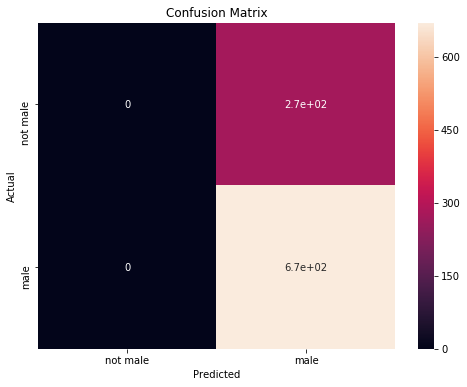

In [59]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns

c_matrix= confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(c_matrix, index = [i for i in ['not male', 'male']], 
                     columns = [i for i in ['not male', 'male']])
plt.figure(figsize = (8,6))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Observations:

- we can see that the accuracy is very low and and our model is not predicting any non male users